<a href="https://colab.research.google.com/github/mvakhmenin/MindSet/blob/main/Mind_set_ETNA_Time_Series_Library_(Tinkoff)_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD_%D0%BD%D0%B0_%D0%B0%D1%80%D0%BC%D0%B0%D1%82%D1%83%D1%80%D1%83_10%D0%BC%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестирование библиотеки ETNA (Tinkoff) - прогнозирование цен на арматуру 10мм

## Установка библиотек и импорт

In [ ]:
pip install etna

     |████████████████████████████████| 169 kB 4.2 MB/s 
     |████████████████████████████████| 3.4 MB 46.7 MB/s 
     |████████████████████████████████| 155 kB 53.4 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 178 kB 45.6 MB/s 
     |████████████████████████████████| 918 kB 43.7 MB/s 
     |████████████████████████████████| 76.1 MB 49 kB/s 
     |████████████████████████████████| 9.5 MB 16.6 MB/s 
     |████████████████████████████████| 132 kB 19.5 MB/s 
     |████████████████████████████████| 8.5 MB 34.2 MB/s 
     |████████████████████████████████| 79 kB 4.7 MB/s 
     |████████████████████████████████| 138 kB 36.8 MB/s 
     |████████████████████████████████| 25.3 MB 11.6 MB/s 
     |████████████████████████████████| 112 kB 53.0 MB/s 
     |████████████████████████████████| 596 kB 36.6 MB/s 
     |████████████████████████████████| 127 kB 52.3 MB/s 
     |███████████████

In [ ]:
pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 2.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from etna.datasets import TSDataset
from etna.models import CatBoostModelMultiSegment
from etna.metrics import SMAPE, MAPE, MAE

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.7/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.7/dist-packages/etna/settings.py:53: UserWarning: etna[prophet] is not available, to install it, run `pip install etna[prophet]`
  warnings.warn("etna[prophet] is not available, to install it, run `pip install etna[prophet]`")


## Импорт данных

### Прогнозируемая переменная (арматура 10мм)

In [ ]:
df_init = pd.read_excel('https://github.com/mvakhmenin/datasets/raw/main/rebar.xls', skiprows=8)
df_init = pd.DataFrame(df_init.iloc[1,:]).T
df_init.drop(inplace=True, columns=['Направление',
                                    'Описание', 
                                    'Страна', 
                                    'Регион',
                                    'Производитель', 
                                    'Страна-контрагент', 
                                    'Условия', 
                                    'Единица',	
                                    'Налоги', 
                                    'Пункт поставки',	
                                    'Контрактование'])
df_init.index = df_init['Продукция'] + ' ' + df_init['Сортамент']
df_metall = df_init.T.drop(index=['Продукция', 'Сортамент'])
df_metall.index = pd.to_datetime(df_metall.index, format='%d.%m.%Y')
df_metall['Арматура 10 мм'] = pd.to_numeric(df_metall['Арматура 10 мм'])
df_metall.drop('2018-01-05', inplace=True)
df_metall.reset_index(inplace=True)
df_metall

,index,Арматура 10 мм
0,2018-01-12,36850.0
1,2018-01-19,36850.0
2,2018-01-26,35200.0
3,2018-02-02,34650.0
4,2018-02-09,35250.0
...,...,...
194,2021-10-01,58250.0
195,2021-10-08,61250.0
196,2021-10-15,66250.0
197,2021-10-22,75500.0


In [ ]:
df_metall.loc[134,'Арматура 10 мм'] = 39125

In [ ]:
df_metall.columns = ['timestamp', 'target']
df_metall['segment'] = 'Арматура 10 мм'
df_metall

,timestamp,target,segment
0,2018-01-12,36850.0,Арматура 10 мм
1,2018-01-19,36850.0,Арматура 10 мм
2,2018-01-26,35200.0,Арматура 10 мм
3,2018-02-02,34650.0,Арматура 10 мм
4,2018-02-09,35250.0,Арматура 10 мм
...,...,...,...
194,2021-10-01,58250.0,Арматура 10 мм
195,2021-10-08,61250.0,Арматура 10 мм
196,2021-10-15,66250.0,Арматура 10 мм
197,2021-10-22,75500.0,Арматура 10 мм


### Регрессоры из Greykite

In [ ]:
df_gk_regressors = pd.read_csv('https://github.com/mvakhmenin/datasets/raw/main/data_weekly_20220206.csv', sep=';', parse_dates=['datetime'])
df_gk_regressors = df_gk_regressors[['datetime', 
                                     'production_all_coke', 
                                     'exchange_rate_usd', 
                                     'scrap_price_lme_M15', 
                                     'production_rus_coke', 
                                     'production_rus_concentrate', 
                                     'prod_prices_reinf_inn_mean', 
                                     'production_rus_pellets', 
                                     'reinforcement_price_lme_M1']]
df_gk_regressors.set_index('datetime', inplace=True)
df_gk_regressors = df_gk_regressors.loc['2018-01-12':'2021-10-29',:]
df_gk_regressors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2018-01-12 to 2021-10-29
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   production_all_coke         45 non-null     float64
 1   exchange_rate_usd           939 non-null    float64
 2   scrap_price_lme_M15         962 non-null    float64
 3   production_rus_coke         45 non-null     float64
 4   production_rus_concentrate  45 non-null     float64
 5   prod_prices_reinf_inn_mean  45 non-null     float64
 6   production_rus_pellets      45 non-null     float64
 7   reinforcement_price_lme_M1  962 non-null    float64
dtypes: float64(8)
memory usage: 97.5 KB


In [ ]:
for column in range(len(df_gk_regressors.columns)):
  if np.isnan(df_gk_regressors.iloc[0,column]):
    df_gk_regressors.iloc[0,column] = df_gk_regressors[~df_gk_regressors.iloc[:,column].isna()].iloc[:,column][0]

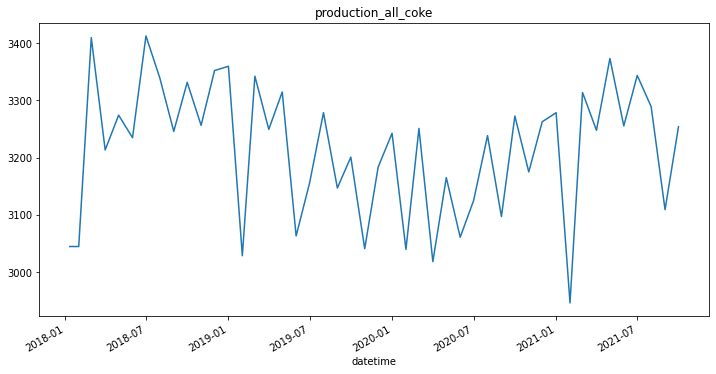

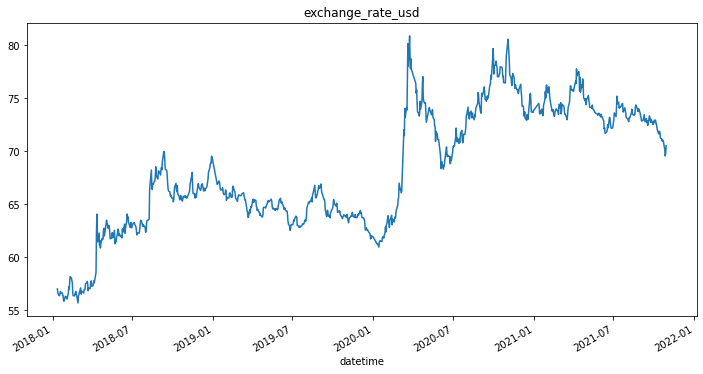

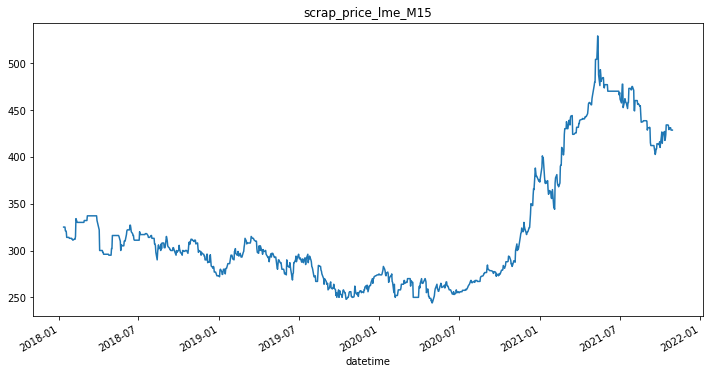

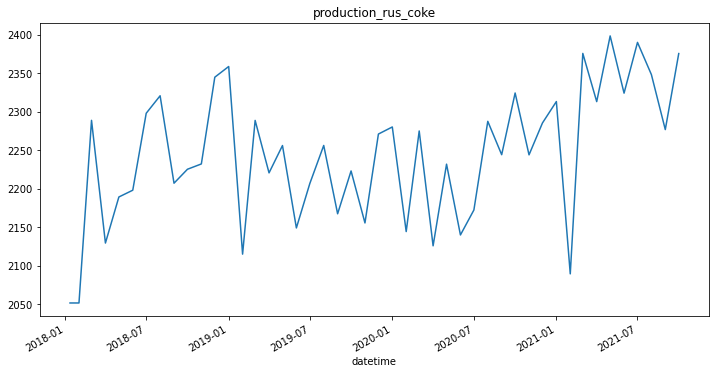

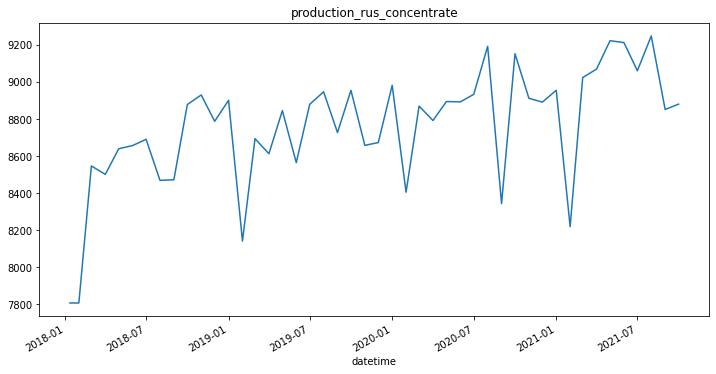

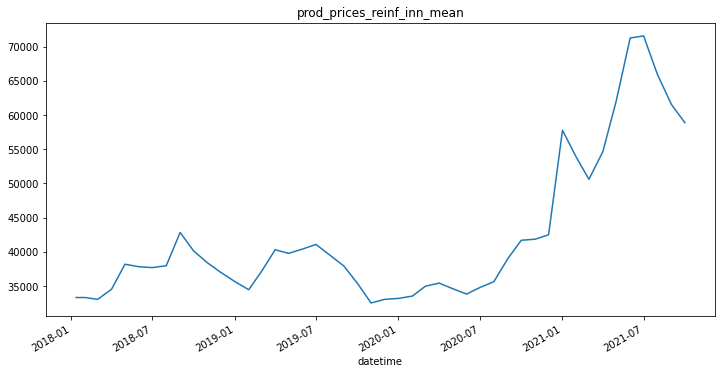

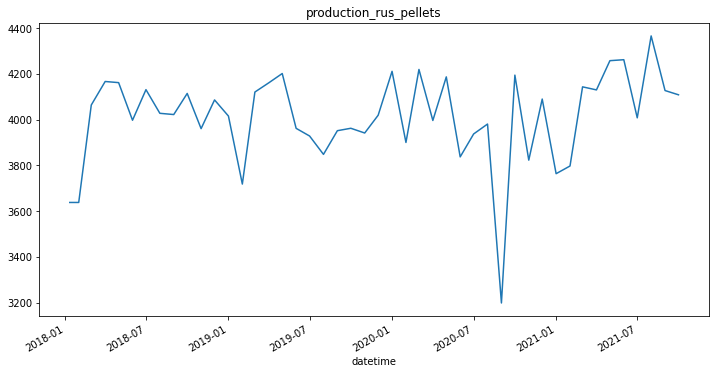

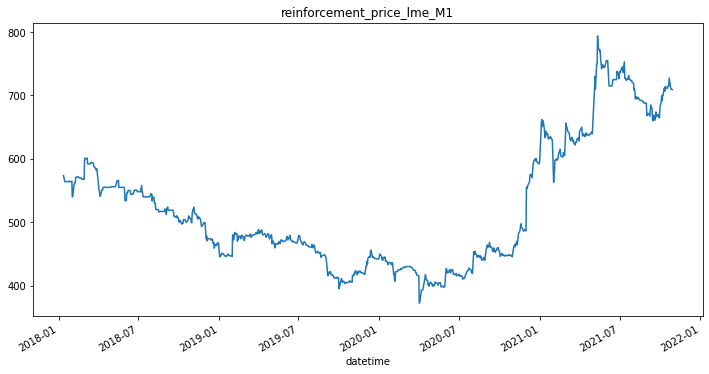

In [ ]:
for column in df_gk_regressors.columns:
  df_gk_regressors[~df_gk_regressors[column].isna()][column].plot(kind='line', figsize=(12,6), title=column)
  plt.show()

In [ ]:
df_metall = df_metall.merge(df_gk_regressors, how='left', left_on='timestamp', right_index=True)
df_metall

,timestamp,target,segment,production_all_coke,exchange_rate_usd,scrap_price_lme_M15,production_rus_coke,production_rus_concentrate,prod_prices_reinf_inn_mean,production_rus_pellets,reinforcement_price_lme_M1
0,2018-01-12,36850.0,Арматура 10 мм,3044.7,56.9957,325.0,2051.8,7806.3,33325.500000,3637.5,573.50
1,2018-01-19,36850.0,Арматура 10 мм,NaN,56.7597,314.0,NaN,NaN,NaN,NaN,564.00
2,2018-01-26,35200.0,Арматура 10 мм,NaN,55.9288,313.0,NaN,NaN,NaN,NaN,564.00
3,2018-02-02,34650.0,Арматура 10 мм,NaN,56.2613,311.0,NaN,NaN,NaN,NaN,540.00
4,2018-02-09,35250.0,Арматура 10 мм,NaN,57.6736,334.0,NaN,NaN,NaN,NaN,571.00
...,...,...,...,...,...,...,...,...,...,...,...
194,2021-10-01,58250.0,Арматура 10 мм,3253.8,72.6642,410.0,2375.6,8879.5,58868.421053,4108.1,681.00
195,2021-10-08,61250.0,Арматура 10 мм,NaN,72.2854,424.0,NaN,NaN,NaN,NaN,700.00
196,2021-10-15,66250.0,Арматура 10 мм,NaN,71.7846,434.0,NaN,NaN,NaN,NaN,711.50
197,2021-10-22,75500.0,Арматура 10 мм,NaN,70.9904,431.0,NaN,NaN,NaN,NaN,727.50


### Замена пропущенных значений

In [ ]:
def nan_ffill(df, column):
  if np.isnan(df.loc[0,column]):
    ffill_value = np.float(df[~df.loc[:,column].isna()].loc[:,column][0])
    df.loc[0, column] = ffill_value
  for i in range(len(df)):
    value = np.float(df.loc[i, column])
    if np.isnan(value):
      df.loc[i, column] = ffill_value
    else:
      ffill_value = value

In [ ]:
for column in ['target', 'production_all_coke',
       'exchange_rate_usd', 'scrap_price_lme_M15', 'production_rus_coke',
       'production_rus_concentrate', 'prod_prices_reinf_inn_mean',
       'production_rus_pellets', 'reinforcement_price_lme_M1']:
  nan_ffill(df_metall, column)

### Конвертация в TSDataset

ETNA работает со специальным форматом данных TSDataset. Чтобы конвертировать в него pandas dataframe необходимо выполнить следующие требования:
* Столбец с зависимой переменной должен называться target;
* Столбец датами должен называться timestamp
* Если прогнозируется несколько временных рядов, в столбце segment должна быть метка для каждого временного ряда.

Подготовим наш датафрейм для передачи в ETNA

In [ ]:
df = TSDataset.to_dataset(df_metall[['timestamp','target','segment']])
df

segment,Арматура 10 мм
feature,target
timestamp,
2018-01-12,36850.0
2018-01-19,36850.0
2018-01-26,35200.0
2018-02-02,34650.0
2018-02-09,35250.0
...,...
2021-10-01,58250.0
2021-10-08,61250.0


In [ ]:
ts = TSDataset(df, freq="W-FRI")
ts

segment,Арматура 10 мм
feature,target
timestamp,
2018-01-12,36850.0
2018-01-19,36850.0
2018-01-26,35200.0
2018-02-02,34650.0
2018-02-09,35250.0
...,...
2021-10-01,58250.0
2021-10-08,61250.0


In [ ]:
df_exog = df_metall[['timestamp',
                     'production_all_coke',
                        'exchange_rate_usd',
                        'scrap_price_lme_M15',
                        'production_rus_coke',
                        'production_rus_concentrate',
                        'prod_prices_reinf_inn_mean',
                        'production_rus_pellets',
                        'reinforcement_price_lme_M1']]
df_exog['segment'] = df_metall['segment']
df = TSDataset.to_dataset(df_metall[['timestamp','target','segment']])
df_exog = TSDataset.to_dataset(df_exog)

ts_X = TSDataset(df=df, df_exog=df_exog, freq="W-FRI")

ts_X

segment       Арматура 10 мм  ...         
feature    exchange_rate_usd  ...   target
timestamp                     ...         
2018-01-12           56.9957  ...  36850.0
2018-01-19           56.7597  ...  36850.0
2018-01-26           55.9288  ...  35200.0
2018-02-02           56.2613  ...  34650.0
2018-02-09           57.6736  ...  35250.0
...                      ...  ...      ...
2021-10-01           72.6642  ...  58250.0
2021-10-08           72.2854  ...  61250.0
2021-10-15           71.7846  ...  66250.0
2021-10-22           70.9904  ...  75500.0
2021-10-29           70.5207  ...  79500.0

[199 rows x 9 columns]

In [ ]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,freq
segments,,,,,,,,
Арматура 10 мм,2018-01-12,2021-10-29,199,0,1,0,0,W-FRI


In [ ]:
ts_X.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,freq
segments,,,,,,,,
Арматура 10 мм,2018-01-12,2021-10-29,199,0,1,8,0,W-FRI


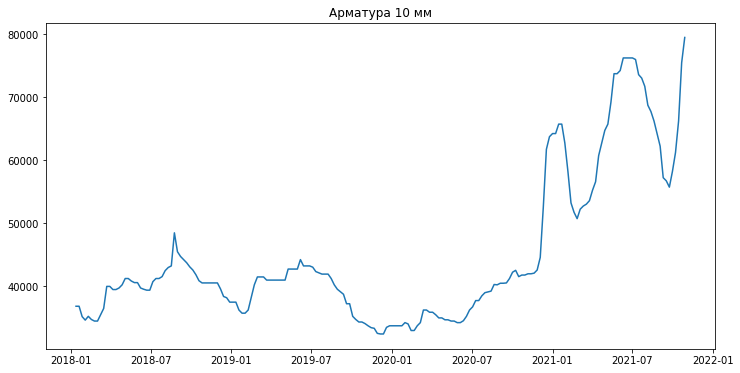

In [ ]:
ts.plot(figsize=(12,6))

## Прогнозирование с помощью ETNA

In [ ]:
from etna.analysis import plot_forecast
from etna.metrics import SMAPE

HORIZON = 12
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
future_ts = train_ts.make_future(HORIZON) # !!! необходимо пересоздавать для каждого нового прогноза
smape = SMAPE()
df_results = pd.DataFrame(columns=['Model', 'SMAPE'])

In [ ]:
print(train_ts.info())
print(test_ts.info())

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
freq: W-FRI
               start_timestamp end_timestamp  length  num_missing
segments                                                         
Арматура 10 мм      2018-01-12    2021-08-06     187            0
None
<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
freq: W-FRI
               start_timestamp end_timestamp  length  num_missing
segments                                                         
Арматура 10 мм      2021-08-13    2021-10-29      12            0
None


In [ ]:
future_ts

segment,Арматура 10 мм
feature,target
timestamp,
2021-08-13,NaN
2021-08-20,NaN
2021-08-27,NaN
2021-09-03,NaN
2021-09-10,NaN
2021-09-17,NaN
2021-09-24,NaN
2021-10-01,NaN


### Простой прогноз (NaiveModel)

Берутся последние фактические значения (lag) и копируются в прогноз на длину горизонта

SMAPE NaiveModel {'Арматура 10 мм': 14.867386844004013}


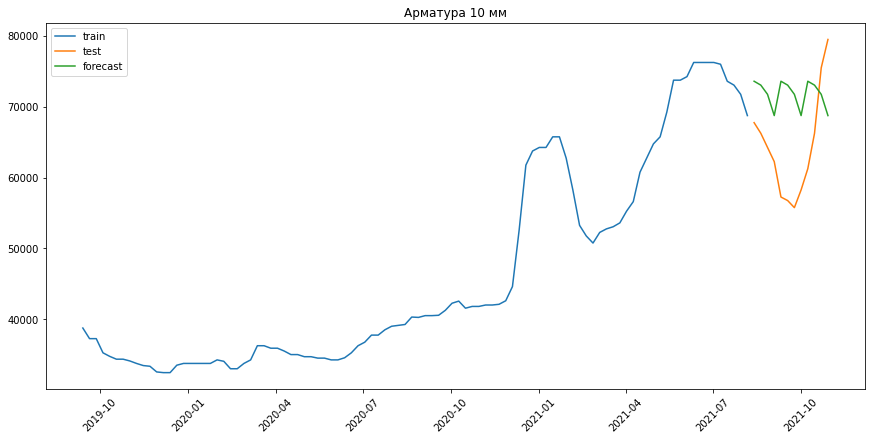

In [ ]:
from etna.models import NaiveModel
model = NaiveModel(lag=4)
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['NaiveModel', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE NaiveModel', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

### Линейная модель (ElasticNet)

In [ ]:
from etna.models import ElasticMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import LagTransform

train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
forecaster = ElasticMultiSegmentModel()
best_smape = 100

for lags in range(1,30):
  lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+lags)))
  model = Pipeline(model=forecaster,
                transforms=[lags_target],
                horizon=HORIZON)
  model.fit(train_ts)
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  cur_smape = smape(y_true=test_ts, y_pred=forecast_ts)['Арматура 10 мм']
  print(f'ElasticNet c лагами = {lags}: SMAPE = {cur_smape:.2f}%')
  if cur_smape < best_smape:
    best_smape = cur_smape
    best_lag = lags
print(f'Лучшая модель с лагами = {best_lag}, SMAPE = {best_smape:.2f}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


ElasticNet c лагами = 1: SMAPE = 22.42%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


ElasticNet c лагами = 2: SMAPE = 22.73%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


ElasticNet c лагами = 3: SMAPE = 23.48%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


ElasticNet c лагами = 4: SMAPE = 24.64%


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 5: SMAPE = 25.30%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 6: SMAPE = 26.00%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 7: SMAPE = 26.10%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


ElasticNet c лагами = 8: SMAPE = 26.37%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 9: SMAPE = 26.47%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 10: SMAPE = 26.50%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 11: SMAPE = 26.51%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 12: SMAPE = 26.52%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 13: SMAPE = 26.69%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 14: SMAPE = 26.76%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 15: SMAPE = 26.75%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


ElasticNet c лагами = 16: SMAPE = 26.14%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


ElasticNet c лагами = 17: SMAPE = 24.73%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


ElasticNet c лагами = 18: SMAPE = 22.89%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


ElasticNet c лагами = 19: SMAPE = 21.44%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


ElasticNet c лагами = 20: SMAPE = 20.05%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


ElasticNet c лагами = 21: SMAPE = 18.68%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


ElasticNet c лагами = 22: SMAPE = 17.23%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


ElasticNet c лагами = 23: SMAPE = 16.07%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


ElasticNet c лагами = 24: SMAPE = 16.68%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


ElasticNet c лагами = 25: SMAPE = 18.58%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


ElasticNet c лагами = 26: SMAPE = 20.57%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


ElasticNet c лагами = 27: SMAPE = 21.85%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


ElasticNet c лагами = 28: SMAPE = 22.51%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


ElasticNet c лагами = 29: SMAPE = 22.51%
Лучшая модель с лагами = 23, SMAPE = 16.07%


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


SMAPE ElasticNet {'Арматура 10 мм': 16.07120047155999}


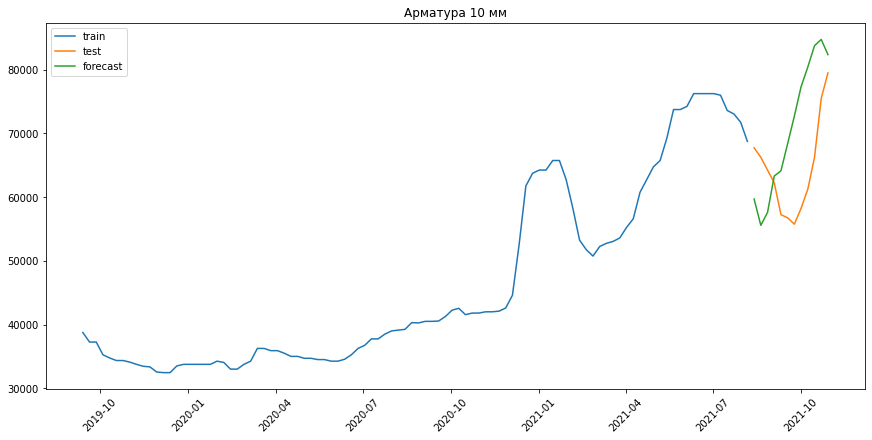

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+best_lag)))
forecaster = ElasticMultiSegmentModel()
model = Pipeline(model=forecaster,
                transforms=[lags_target],
                horizon=HORIZON)
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['ElasticNet', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE ElasticNet', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

### Экспоненциальное сглаживание

In [ ]:
from etna.models import HoltModel

best_smape = 100

for alpha in [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]:
  for beta in [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]:
    model = HoltModel(smoothing_level=alpha, smoothing_trend=beta)
    model.fit(train_ts)
    future_ts = train_ts.make_future(HORIZON)
    forecast_ts = model.forecast(future_ts)
    cur_smape = smape(y_true=test_ts, y_pred=forecast_ts)['Арматура 10 мм']
    print(f'HoltModel c параметрами alpha = {alpha}, beta = {beta}: SMAPE = {cur_smape:.2f}%')
    if cur_smape < best_smape:
      best_smape = cur_smape
      best_alpha = alpha
      best_beta = beta
print(f'Лучшая модель c параметрами alpha = {best_alpha}, beta = {best_beta}: SMAPE = {best_smape:.2f}%')

HoltModel c параметрами alpha = 0.01, beta = 0.01: SMAPE = 10.73%
HoltModel c параметрами alpha = 0.01, beta = 0.05: SMAPE = 12.86%
HoltModel c параметрами alpha = 0.01, beta = 0.1: SMAPE = 8.95%
HoltModel c параметрами alpha = 0.01, beta = 0.3: SMAPE = 27.44%
HoltModel c параметрами alpha = 0.01, beta = 0.5: SMAPE = 31.51%
HoltModel c параметрами alpha = 0.01, beta = 0.8: SMAPE = 23.95%
HoltModel c параметрами alpha = 0.05, beta = 0.01: SMAPE = 9.92%
HoltModel c параметрами alpha = 0.05, beta = 0.05: SMAPE = 20.95%
HoltModel c параметрами alpha = 0.05, beta = 0.1: SMAPE = 26.83%
HoltModel c параметрами alpha = 0.05, beta = 0.3: SMAPE = 24.98%
HoltModel c параметрами alpha = 0.05, beta = 0.5: SMAPE = 27.90%
HoltModel c параметрами alpha = 0.05, beta = 0.8: SMAPE = 41.27%
HoltModel c параметрами alpha = 0.1, beta = 0.01: SMAPE = 15.06%
HoltModel c параметрами alpha = 0.1, beta = 0.05: SMAPE = 23.55%
HoltModel c параметрами alpha = 0.1, beta = 0.1: SMAPE = 24.89%
HoltModel c параметрами 

SMAPE HoltModel {'Арматура 10 мм': 8.953411365315429}


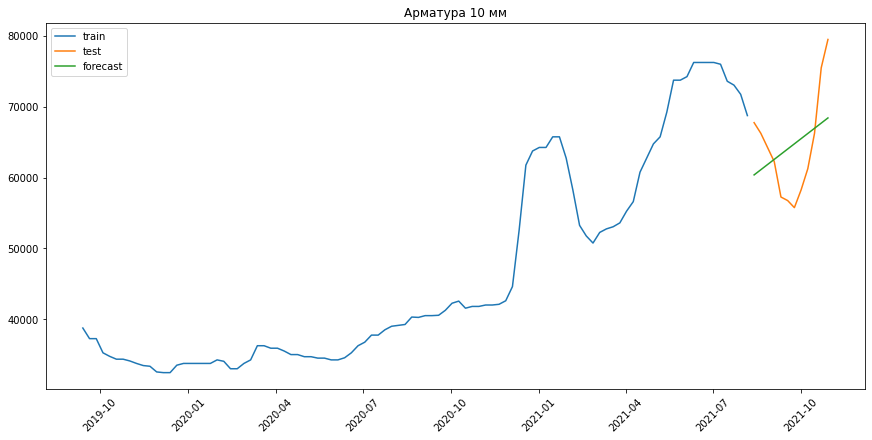

In [ ]:
model = HoltModel(smoothing_level=best_alpha, smoothing_trend=best_beta)
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['Двойное эксп. сглаживание', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE HoltModel', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

In [ ]:
from etna.models import HoltWintersModel

best_smape = 100

for alpha in [0.05, 0.1, 0.3, 0.5]:
  for beta in [0.05, 0.1, 0.3, 0.5]:
    for gama in [0.05, 0.1, 0.3, 0.5]:
      for speriods in [3,6,9,12]:
        model = HoltWintersModel(trend='add', smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gama, seasonal='add', seasonal_periods=speriods)
        model.fit(train_ts)
        future_ts = train_ts.make_future(HORIZON)
        forecast_ts = model.forecast(future_ts)
        cur_smape = smape(y_true=test_ts, y_pred=forecast_ts)['Арматура 10 мм']
        print(f'HoltWintersModel c параметрами alpha={alpha}, beta={beta}, gama={gama}, speriods={speriods}: SMAPE = {cur_smape:.2f}%')
        if cur_smape < best_smape:
          best_smape = cur_smape
          best_alpha = alpha
          best_beta = beta
          best_gama = gama
          best_speriods = speriods
print(f'Лучшая модель c параметрами alpha = {best_alpha}, beta = {best_beta}, gama = {best_gama}, период сезонности = {best_speriods}: SMAPE = {best_smape:.2f}%')

HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.05, speriods=3: SMAPE = 20.36%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.05, speriods=6: SMAPE = 20.77%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.05, speriods=9: SMAPE = 20.91%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.05, speriods=12: SMAPE = 21.11%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.1, speriods=3: SMAPE = 19.95%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.1, speriods=6: SMAPE = 20.61%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.1, speriods=9: SMAPE = 20.85%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.1, speriods=12: SMAPE = 21.15%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.3, speriods=3: SMAPE = 19.12%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.3, speriods=6: SMAPE = 20.28%
HoltWintersModel c параметрами alpha=0.05, beta=0.05, gama=0.3, speriods=9: SMAPE = 

SMAPE HoltWintersModel {'Арматура 10 мм': 10.337283139679327}


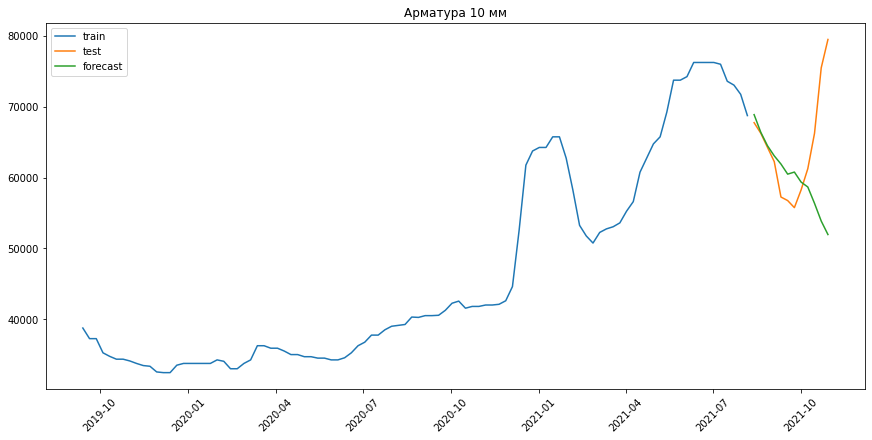

In [ ]:
model = HoltWintersModel(trend='add', smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gama, seasonal='add', seasonal_periods=best_speriods)
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['Тройное эксп. сглаживание', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE HoltWintersModel', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

### CatBoost

Простой CatBoost с лагами

In [ ]:
lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+24)))
train_ts.fit_transform([lags])

In [ ]:
train_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,freq
segments,,,,,,,,
Арматура 10 мм,2018-01-12,2021-08-06,187,0,1,24,24,W-FRI


In [ ]:
train_ts

segment                                                                    Арматура 10 мм  ...         
feature    regressor_LagTransform(in_column = 'target', lags = [12], out_column = None, )  ...   target
timestamp                                                                                  ...         
2018-01-12                                                NaN                              ...  36850.0
2018-01-19                                                NaN                              ...  36850.0
2018-01-26                                                NaN                              ...  35200.0
2018-02-02                                                NaN                              ...  34650.0
2018-02-09                                                NaN                              ...  35250.0
...                                                       ...                              ...      ...
2021-07-09                                            60750.0                              ...  76000.0
2021-07-16                                            62750.0                              ...  73600.0
2021-07-23                                            64750.0                              ...  73050.0
2021-07-30                                            65750.0                              ...  71750.0
2021-08-06                                            69250.0                              ...  68750.0

[187 rows x 25 columns]

In [ ]:
from etna.models import CatBoostModelMultiSegment

train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
forecaster = CatBoostModelMultiSegment(logging_level = 'Silent')
best_smape = 100

for lags in range(1,24):
  lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+lags)))
  model = Pipeline(model=forecaster,
                transforms=[lags_target],
                horizon=HORIZON)
  model.fit(train_ts)
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  cur_smape = smape(y_true=test_ts, y_pred=forecast_ts)['Арматура 10 мм']
  print(f'CatBoost c лагами = {lags}: SMAPE = {cur_smape:.2f}%')
  if cur_smape < best_smape:
    best_smape = cur_smape
    best_lag = lags
print(f'Лучшая модель с лагами = {best_lag}, SMAPE = {best_smape:.2f}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


CatBoost c лагами = 1: SMAPE = 10.40%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s finished


CatBoost c лагами = 2: SMAPE = 10.39%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


CatBoost c лагами = 3: SMAPE = 10.62%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


CatBoost c лагами = 4: SMAPE = 8.67%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s finished


CatBoost c лагами = 5: SMAPE = 8.66%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


CatBoost c лагами = 6: SMAPE = 8.93%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s finished


CatBoost c лагами = 7: SMAPE = 8.58%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished


CatBoost c лагами = 8: SMAPE = 8.29%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s finished


CatBoost c лагами = 9: SMAPE = 8.42%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s finished


CatBoost c лагами = 10: SMAPE = 9.70%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s finished


CatBoost c лагами = 11: SMAPE = 11.94%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished


CatBoost c лагами = 12: SMAPE = 12.98%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s finished


CatBoost c лагами = 13: SMAPE = 13.71%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


CatBoost c лагами = 14: SMAPE = 14.02%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s finished


CatBoost c лагами = 15: SMAPE = 13.88%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s finished


CatBoost c лагами = 16: SMAPE = 14.62%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s finished


CatBoost c лагами = 17: SMAPE = 14.36%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s finished


CatBoost c лагами = 18: SMAPE = 14.55%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s finished


CatBoost c лагами = 19: SMAPE = 15.50%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s finished


CatBoost c лагами = 20: SMAPE = 15.17%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s finished


CatBoost c лагами = 21: SMAPE = 15.44%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s finished


CatBoost c лагами = 22: SMAPE = 14.71%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


CatBoost c лагами = 23: SMAPE = 14.37%
Лучшая модель с лагами = 8, SMAPE = 8.29%


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s finished


SMAPE CatBoost {'Арматура 10 мм': 8.286302792287612}


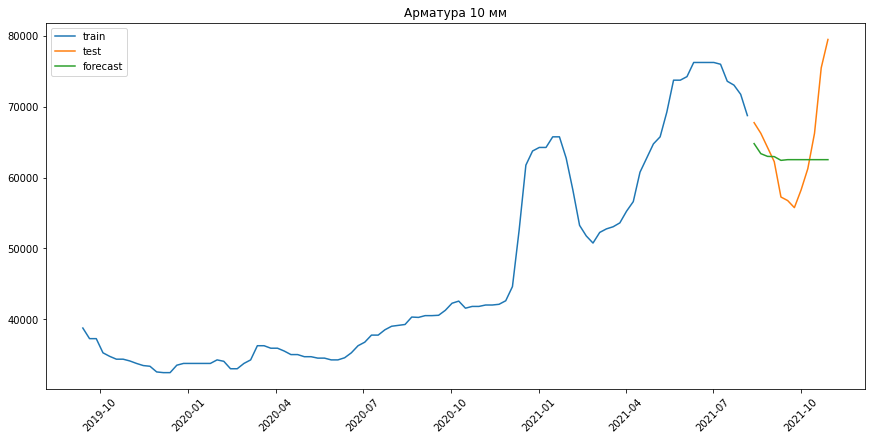

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+best_lag)))
train_ts.fit_transform([lags])

model = CatBoostModelMultiSegment(logging_level = 'Silent')
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['CatBoost с лагами', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE CatBoost', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

### CatBoost для стационарного временного ряда

In [ ]:
from etna.transforms.math.differencing import DifferencingTransform
from etna.transforms import MeanTransform, LagTransform, LogTransform, \
    SegmentEncoderTransform, DateFlagsTransform, LinearTrendTransform
import statsmodels as sm

В ETNA есть трансформеры, позволяющие привести временной ряд к стационарному

Критерий Дикки-Фуллера: -6.4587859836
p-value: 0.0000000146
Критические значения {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}
Ряд стационарный, так как значение критерия Дикки-Фуллера (-6.4587859836) меньше критического значения 1% (-3.4674201432)


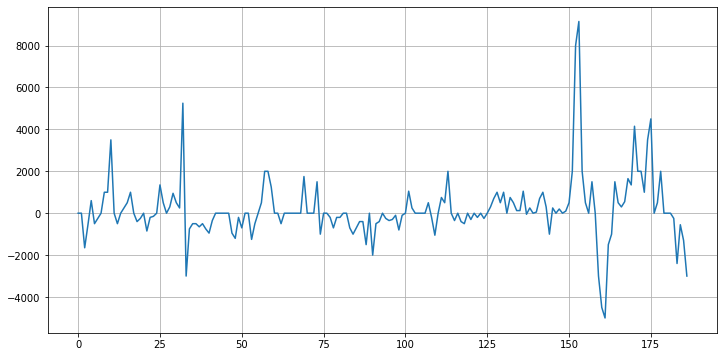

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
diff = DifferencingTransform(in_column="target")
train_ts.fit_transform([diff])

y_hat = train_ts.to_pandas(flatten=True)['target'].fillna(0)
y_hat.plot(figsize=(12,6), grid=True)
print(f'Критерий Дикки-Фуллера: {sm.tsa.stattools.adfuller(y_hat)[0]:.10f}')
print(f'p-value: {sm.tsa.stattools.adfuller(y_hat)[1]:.10f}')
print(f'Критические значения {sm.tsa.stattools.adfuller(y_hat)[4]}')
if sm.tsa.stattools.adfuller(y_hat)[0] > sm.tsa.stattools.adfuller(y_hat)[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({sm.tsa.stattools.adfuller(y_hat)[0]:.10f}) больше критического значения 1% ({sm.tsa.stattools.adfuller(y_hat)[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({sm.tsa.stattools.adfuller(y_hat)[0]:.10f}) меньше критического значения 1% ({sm.tsa.stattools.adfuller(y_hat)[4]["1%"]:.10f})')

Опытным путем была получена комбинация трафнсформеров с минимальной ошибкой прогноза (trend, diff, lags_target, lags_diff)

In [ ]:
from etna.pipeline import Pipeline

trend = LinearTrendTransform(in_column="target")
diff = DifferencingTransform(in_column="target", out_column='regressor_diff1', inplace=False)
forecaster = CatBoostModelMultiSegment(logging_level = 'Silent')
best_smape = 100

for lags in range(1,24):
  train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
  lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+lags)))
  lags_diff = LagTransform(in_column="regressor_diff1", lags=list(range(HORIZON, HORIZON+lags)))
  model = Pipeline(model=forecaster,
                transforms=[trend, diff, lags_target, lags_diff],
                horizon=HORIZON)
  model.fit(train_ts)
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  cur_smape = smape(y_true=test_ts, y_pred=forecast_ts)['Арматура 10 мм']
  print(f'CatBoost на стационарном ряду c лагами = {lags}: SMAPE = {cur_smape:.2f}%')
  if cur_smape < best_smape:
    best_smape = cur_smape
    best_lag = lags
print(f'Лучшая модель с лагами = {best_lag}, SMAPE = {best_smape:.2f}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


CatBoost на стационарном ряду c лагами = 1: SMAPE = 9.53%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished


CatBoost на стационарном ряду c лагами = 2: SMAPE = 9.34%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s finished


CatBoost на стационарном ряду c лагами = 3: SMAPE = 9.16%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s finished


CatBoost на стационарном ряду c лагами = 4: SMAPE = 8.51%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s finished


CatBoost на стационарном ряду c лагами = 5: SMAPE = 7.84%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.0s finished


CatBoost на стационарном ряду c лагами = 6: SMAPE = 8.80%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s finished


CatBoost на стационарном ряду c лагами = 7: SMAPE = 8.58%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s finished


CatBoost на стационарном ряду c лагами = 8: SMAPE = 7.62%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s finished


CatBoost на стационарном ряду c лагами = 9: SMAPE = 7.76%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s finished


CatBoost на стационарном ряду c лагами = 10: SMAPE = 7.73%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.4s finished


CatBoost на стационарном ряду c лагами = 11: SMAPE = 7.82%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s finished


CatBoost на стационарном ряду c лагами = 12: SMAPE = 8.09%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.4s finished


CatBoost на стационарном ряду c лагами = 13: SMAPE = 9.24%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s finished


CatBoost на стационарном ряду c лагами = 14: SMAPE = 9.20%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s finished


CatBoost на стационарном ряду c лагами = 15: SMAPE = 9.55%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s finished


CatBoost на стационарном ряду c лагами = 16: SMAPE = 9.73%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s finished


CatBoost на стационарном ряду c лагами = 17: SMAPE = 10.17%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s finished


CatBoost на стационарном ряду c лагами = 18: SMAPE = 10.74%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s finished


CatBoost на стационарном ряду c лагами = 19: SMAPE = 10.27%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished


CatBoost на стационарном ряду c лагами = 20: SMAPE = 9.81%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.0s finished


CatBoost на стационарном ряду c лагами = 21: SMAPE = 10.11%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


CatBoost на стационарном ряду c лагами = 22: SMAPE = 9.59%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


CatBoost на стационарном ряду c лагами = 23: SMAPE = 8.85%
Лучшая модель с лагами = 8, SMAPE = 7.62%


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.7s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s finished


SMAPE CatBoost {'Арматура 10 мм': 7.619392499554138}


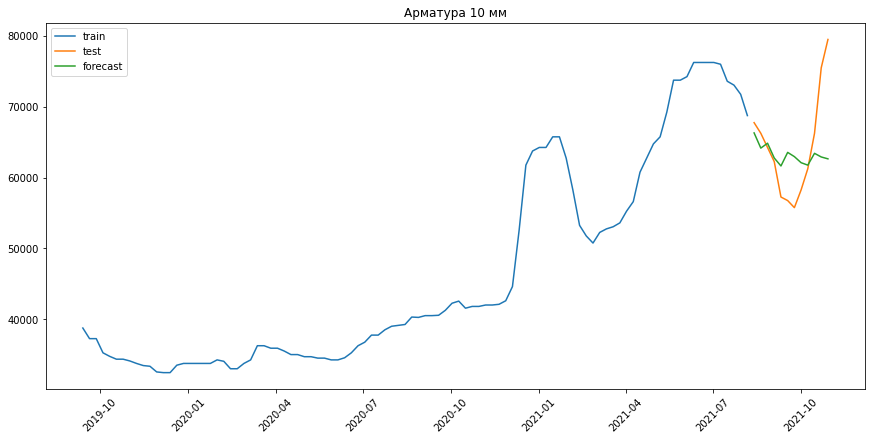

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+best_lag)))
lags_diff = LagTransform(in_column="regressor_diff1", lags=list(range(HORIZON, HORIZON+best_lag)))
forecaster = CatBoostModelMultiSegment(logging_level = 'Silent')

model = Pipeline(model=forecaster,
                transforms=[trend, diff, lags_target, lags_diff],
                horizon=HORIZON)
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['CatBoost стационарный ряд с лагами', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE CatBoost', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

### SARIMAX

In [ ]:
from etna.models import SARIMAXModel

SARIMAX с параметрами по умолчанию

In [ ]:
model = SARIMAXModel()
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

SMAPE CatBoost {'Арматура 10 мм': 13.68964451552943}


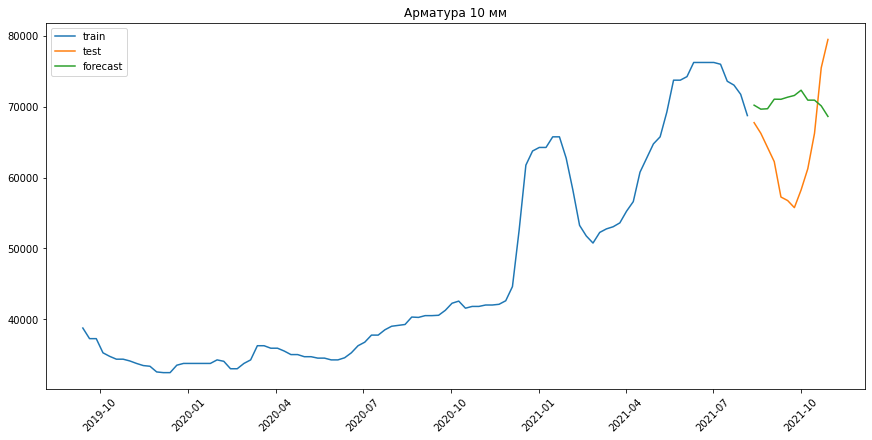

In [ ]:
print('SMAPE CatBoost', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

Подбор параметров SARIMAX

In [ ]:
best_smape = 100
best_order = {}

for p in range(0,5):
  for d in range(0,5):
     for q in range(0,5):
       model = SARIMAXModel(order=(p,d,q), trend='t')
       model.fit(train_ts)
       future_ts = train_ts.make_future(HORIZON)
       forecast_ts = model.forecast(future_ts)
       cur_smape = smape(y_true=test_ts, y_pred=forecast_ts)['Арматура 10 мм']
       print(f'SARIMAX c параметрами (p,d,q) = ({p},{d},{q}): SMAPE = {cur_smape:.2f}%')
       if cur_smape < best_smape:
        best_smape = cur_smape
        best_order['p'] = p
        best_order['d'] = d
        best_order['q'] = q
print(f'Лучшая модель с параметрами (p,d,q) = {best_order}, SMAPE = {best_smape:.2f}%')

SARIMAX c параметрами (p,d,q) = (0,0,0): SMAPE = 23.23%
SARIMAX c параметрами (p,d,q) = (0,0,1): SMAPE = 21.76%
SARIMAX c параметрами (p,d,q) = (0,0,2): SMAPE = 20.25%
SARIMAX c параметрами (p,d,q) = (0,0,3): SMAPE = 18.90%
SARIMAX c параметрами (p,d,q) = (0,0,4): SMAPE = 19.60%
SARIMAX c параметрами (p,d,q) = (0,1,0): SMAPE = 16.34%
SARIMAX c параметрами (p,d,q) = (0,1,1): SMAPE = 15.20%
SARIMAX c параметрами (p,d,q) = (0,1,2): SMAPE = 14.67%
SARIMAX c параметрами (p,d,q) = (0,1,3): SMAPE = 14.39%
SARIMAX c параметрами (p,d,q) = (0,1,4): SMAPE = 13.84%
SARIMAX c параметрами (p,d,q) = (0,2,0): SMAPE = 70.95%
SARIMAX c параметрами (p,d,q) = (0,2,1): SMAPE = 53.90%
SARIMAX c параметрами (p,d,q) = (0,2,2): SMAPE = 39.98%
SARIMAX c параметрами (p,d,q) = (0,2,3): SMAPE = 34.57%
SARIMAX c параметрами (p,d,q) = (0,2,4): SMAPE = 37.32%
SARIMAX c параметрами (p,d,q) = (0,3,0): SMAPE = 156.35%
SARIMAX c параметрами (p,d,q) = (0,3,1): SMAPE = 82.38%
SARIMAX c параметрами (p,d,q) = (0,3,2): SMAPE 

SMAPE SARIMAX {'Арматура 10 мм': 9.375341448679404}


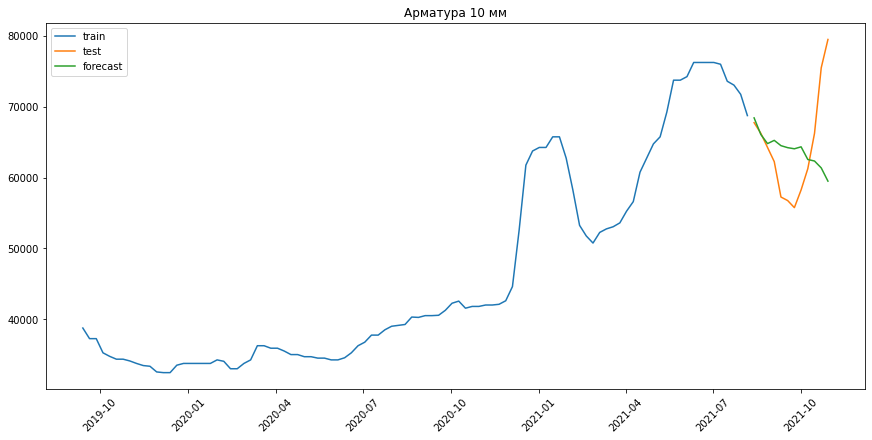

In [ ]:
model = SARIMAXModel(order=(best_order['p'],best_order['d'],best_order['q']), trend='t')
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['SARIMAX', f'{smape(y_true=test_ts, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE SARIMAX', smape(y_true=test_ts, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100, figsize=(12,6))

## Прогнозирование с экзогенными данными

### Линейная модель (ElasticNet)

In [ ]:
df_exog = df_metall[['timestamp',
                     'production_all_coke',
                        'exchange_rate_usd',
                        'scrap_price_lme_M15',
                        'production_rus_coke',
                        'production_rus_concentrate',
                        'prod_prices_reinf_inn_mean',
                        'production_rus_pellets',
                        'reinforcement_price_lme_M1']]
df_exog['timestamp'] = df_metall['timestamp']
df_exog['segment'] = df_metall['segment']
df = TSDataset.to_dataset(df_metall[['timestamp','target','segment']])
df_exog = TSDataset.to_dataset(df_exog)

ts_X = TSDataset(df=df, df_exog=df_exog, freq="W-FRI")

In [ ]:
train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+1)))
forecaster = ElasticMultiSegmentModel()
best_smape = 100

for lags in range(1,30):
  train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
  lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+lags)))
  model = Pipeline(model=forecaster,
                transforms=[lags_target],
                horizon=HORIZON)
  model.fit(train_ts_X)
  future_ts = train_ts_X.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  cur_smape = smape(y_true=test_ts_X, y_pred=forecast_ts)['Арматура 10 мм']
  print(f'ElasticNet c лагами = {lags}: SMAPE = {cur_smape:.2f}%')
  if cur_smape < best_smape:
    best_smape = cur_smape
    best_lag = lags
print(f'Лучшая модель с лагами = {best_lag}, SMAPE = {best_smape:.2f}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 1: SMAPE = 9.02%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 2: SMAPE = 10.01%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 3: SMAPE = 10.37%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 4: SMAPE = 11.12%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 5: SMAPE = 11.75%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 6: SMAPE = 12.36%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 7: SMAPE = 12.72%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 8: SMAPE = 12.80%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet c лагами = 9: SMAPE = 12.57%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 10: SMAPE = 12.24%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 11: SMAPE = 11.56%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 12: SMAPE = 11.12%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


ElasticNet c лагами = 13: SMAPE = 11.04%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 14: SMAPE = 10.73%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 15: SMAPE = 10.52%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 16: SMAPE = 9.97%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 17: SMAPE = 9.66%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 18: SMAPE = 9.35%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 19: SMAPE = 9.12%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 20: SMAPE = 9.15%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 21: SMAPE = 9.53%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 22: SMAPE = 10.38%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 23: SMAPE = 10.24%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 24: SMAPE = 12.08%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 25: SMAPE = 13.85%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 26: SMAPE = 14.43%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 27: SMAPE = 14.49%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 28: SMAPE = 14.14%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


ElasticNet c лагами = 29: SMAPE = 13.97%
Лучшая модель с лагами = 1, SMAPE = 9.02%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


SMAPE ElasticNet EXOG {'Арматура 10 мм': 9.015529671573578}


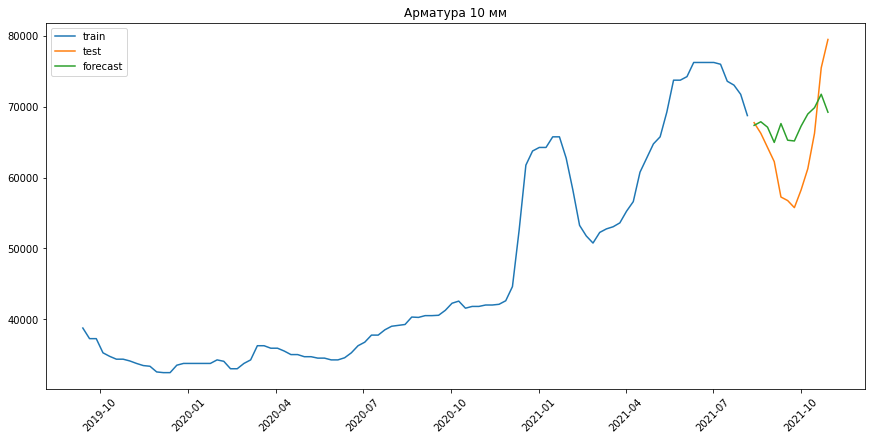

In [ ]:
train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+best_lag)))
forecaster = ElasticMultiSegmentModel()
model = Pipeline(model=forecaster,
                transforms=[lags_target],
                horizon=HORIZON)
model.fit(train_ts_X)
future_ts = train_ts_X.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['ElasticNet  + EXOG', f'{smape(y_true=test_ts_X, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE ElasticNet EXOG', smape(y_true=test_ts_X, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts_X, train_ts_X, n_train_samples=100, figsize=(12,6))

### CatBoost

Простой CatBoost с лагами

In [ ]:
train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
forecaster = CatBoostModelMultiSegment(logging_level = 'Silent')
best_smape = 100

for lags in range(1,30):
  train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
  lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+lags)))
  lags_exog = []
  for _, column in train_ts_X.columns:
    lags_exog.append(LagTransform(in_column=column, lags=list(range(HORIZON, HORIZON+lags))))
  model = Pipeline(model=forecaster,
                transforms=[lags_target, *lags_exog],
                horizon=HORIZON)
  model.fit(train_ts_X)
  future_ts = train_ts_X.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  cur_smape = smape(y_true=test_ts_X, y_pred=forecast_ts)['Арматура 10 мм']
  print(f'CatBoost c лагами = {lags}: SMAPE = {cur_smape:.2f}%')
  if cur_smape < best_smape:
    best_smape = cur_smape
    best_lag = lags
print(f'Лучшая модель с лагами = {best_lag}, SMAPE = {best_smape:.2f}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


CatBoost c лагами = 1: SMAPE = 9.09%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s finished


CatBoost c лагами = 2: SMAPE = 10.34%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s finished


CatBoost c лагами = 3: SMAPE = 10.48%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s finished


CatBoost c лагами = 4: SMAPE = 10.53%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s finished


CatBoost c лагами = 5: SMAPE = 11.68%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s finished


CatBoost c лагами = 6: SMAPE = 12.11%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


CatBoost c лагами = 7: SMAPE = 12.43%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.6s finished


CatBoost c лагами = 8: SMAPE = 13.00%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s finished


CatBoost c лагами = 9: SMAPE = 13.64%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.1s finished


CatBoost c лагами = 10: SMAPE = 13.57%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s finished


CatBoost c лагами = 11: SMAPE = 13.57%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.2s finished


CatBoost c лагами = 12: SMAPE = 13.64%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.0s finished


CatBoost c лагами = 13: SMAPE = 13.98%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s finished


CatBoost c лагами = 14: SMAPE = 14.05%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.9s finished


CatBoost c лагами = 15: SMAPE = 14.00%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.3s finished


CatBoost c лагами = 16: SMAPE = 13.57%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.6s finished


CatBoost c лагами = 17: SMAPE = 12.92%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.7s finished


CatBoost c лагами = 18: SMAPE = 13.08%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.1s finished


CatBoost c лагами = 19: SMAPE = 12.21%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.3s finished


CatBoost c лагами = 20: SMAPE = 12.23%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.2s finished


CatBoost c лагами = 21: SMAPE = 9.02%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s finished


CatBoost c лагами = 22: SMAPE = 9.08%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.6s finished


CatBoost c лагами = 23: SMAPE = 8.69%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.5s finished


CatBoost c лагами = 24: SMAPE = 8.80%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s finished


CatBoost c лагами = 25: SMAPE = 7.60%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.4s finished


CatBoost c лагами = 26: SMAPE = 8.16%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.1s finished


CatBoost c лагами = 27: SMAPE = 8.93%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.6s finished


CatBoost c лагами = 28: SMAPE = 9.11%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.9s remaining:    0.0s


CatBoost c лагами = 29: SMAPE = 9.74%
Лучшая модель с лагами = 25, SMAPE = 7.60%


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.8s finished


SMAPE CatBoost EXOG {'Арматура 10 мм': 7.60010140758649}


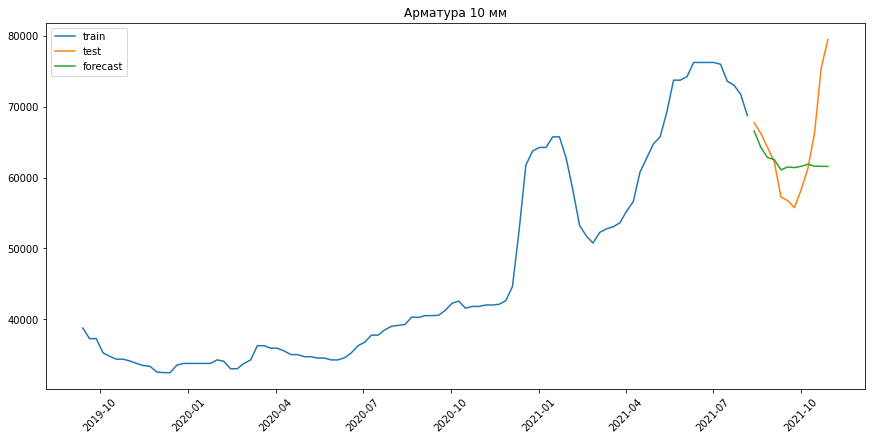

In [ ]:
train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+best_lag)))
lags_exog = []
for _, column in train_ts_X.columns:
    lags_exog.append(LagTransform(in_column=column, lags=list(range(HORIZON, HORIZON+best_lag))))
train_ts_X.fit_transform([lags, *lags_exog])

model = CatBoostModelMultiSegment(logging_level = 'Silent')
model.fit(train_ts_X)
future_ts = train_ts_X.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['CatBoost с лагами + EXOG', f'{smape(y_true=test_ts_X, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE CatBoost EXOG', smape(y_true=test_ts_X, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts_X, train_ts_X, n_train_samples=100, figsize=(12,6))

### CatBoost для стационарного временного ряда

In [ ]:
trend = LinearTrendTransform(in_column="target")
diff = DifferencingTransform(in_column="target", out_column='regressor_diff1', inplace=False)
forecaster = CatBoostModelMultiSegment(logging_level = 'Silent')
best_smape = 100

for lags in range(1,36):
  train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
  lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+lags)))
  lags_diff = LagTransform(in_column="regressor_diff1", lags=list(range(HORIZON, HORIZON+lags)))
  lags_exog = []
  trend_exog = []
  diff_exog = []
  lags_diff_exog = []
  for _, column in train_ts_X.columns:
    lags_exog.append(LagTransform(in_column=column, lags=list(range(HORIZON, HORIZON+lags))))
    trend_exog.append(LinearTrendTransform(in_column=column))
    diff_exog.append(DifferencingTransform(in_column=column, out_column=f'{column}_diff1', inplace=False))
    lags_diff_exog.append(LagTransform(in_column=f'{column}_diff1', lags=list(range(HORIZON, HORIZON+lags))))
  model = Pipeline(model=forecaster,
                transforms=[trend, diff, lags_target, lags_diff, *lags_exog, *trend_exog, *diff_exog, *lags_diff_exog],
                horizon=HORIZON)
  model.fit(train_ts_X)
  future_ts = train_ts_X.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  cur_smape = smape(y_true=test_ts_X, y_pred=forecast_ts)['Арматура 10 мм']
  print(f'CatBoost c лагами = {lags}: SMAPE = {cur_smape:.2f}%')
  if cur_smape < best_smape:
    best_smape = cur_smape
    best_lag = lags
print(f'Лучшая модель с лагами = {best_lag}, SMAPE = {best_smape:.2f}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished


CatBoost c лагами = 1: SMAPE = 11.93%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s finished


CatBoost c лагами = 2: SMAPE = 11.08%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s finished


CatBoost c лагами = 3: SMAPE = 12.43%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s finished


CatBoost c лагами = 4: SMAPE = 11.48%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.6s finished


CatBoost c лагами = 5: SMAPE = 13.47%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s finished


CatBoost c лагами = 6: SMAPE = 12.47%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.0s finished


CatBoost c лагами = 7: SMAPE = 13.31%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.0s finished


CatBoost c лагами = 8: SMAPE = 13.56%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s finished


CatBoost c лагами = 9: SMAPE = 13.92%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.3s finished


CatBoost c лагами = 10: SMAPE = 14.01%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.8s finished


CatBoost c лагами = 11: SMAPE = 13.21%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.5s finished


CatBoost c лагами = 12: SMAPE = 14.47%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.7s finished


CatBoost c лагами = 13: SMAPE = 14.71%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.1s finished


CatBoost c лагами = 14: SMAPE = 14.88%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.1s finished


CatBoost c лагами = 15: SMAPE = 14.46%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.4s finished


CatBoost c лагами = 16: SMAPE = 14.47%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.1s finished


CatBoost c лагами = 17: SMAPE = 14.97%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.2s finished


CatBoost c лагами = 18: SMAPE = 14.29%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.9s finished


CatBoost c лагами = 19: SMAPE = 13.50%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


CatBoost c лагами = 20: SMAPE = 12.03%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


CatBoost c лагами = 21: SMAPE = 11.94%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


CatBoost c лагами = 22: SMAPE = 11.17%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


CatBoost c лагами = 23: SMAPE = 9.34%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


CatBoost c лагами = 24: SMAPE = 10.00%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


CatBoost c лагами = 25: SMAPE = 8.75%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


CatBoost c лагами = 26: SMAPE = 9.82%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


CatBoost c лагами = 27: SMAPE = 7.97%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished


CatBoost c лагами = 28: SMAPE = 9.04%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished


CatBoost c лагами = 29: SMAPE = 8.63%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished


CatBoost c лагами = 30: SMAPE = 8.11%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished


CatBoost c лагами = 31: SMAPE = 7.87%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


CatBoost c лагами = 32: SMAPE = 8.69%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


CatBoost c лагами = 33: SMAPE = 8.63%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


CatBoost c лагами = 34: SMAPE = 9.14%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


CatBoost c лагами = 35: SMAPE = 9.66%
Лучшая модель с лагами = 31, SMAPE = 7.87%


SMAPE CatBoost EXOG (стационарный) {'Арматура 10 мм': 7.874581652100128}


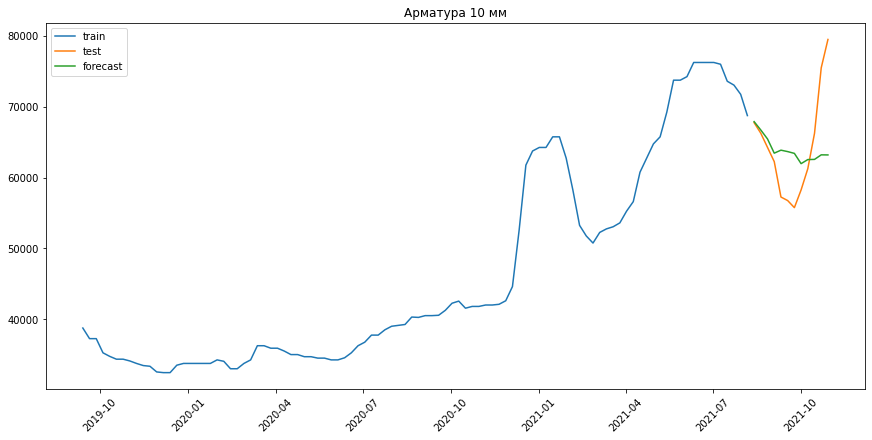

In [ ]:
train_ts_X, test_ts_X = ts_X.train_test_split(test_size=HORIZON)
trend = LinearTrendTransform(in_column="target")
diff = DifferencingTransform(in_column="target", out_column='regressor_diff1', inplace=False)
lags_target = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON+best_lag)))
lags_diff = LagTransform(in_column="regressor_diff1", lags=list(range(HORIZON, HORIZON+best_lag)))
lags_exog = []
trend_exog = []
diff_exog = []
lags_diff_exog = []
for _, column in train_ts_X.columns:
  lags_exog.append(LagTransform(in_column=column, lags=list(range(HORIZON, HORIZON+best_lag))))
  trend_exog.append(LinearTrendTransform(in_column=column))
  diff_exog.append(DifferencingTransform(in_column=column, out_column=f'{column}_diff1', inplace=False))
  lags_diff_exog.append(LagTransform(in_column=f'{column}_diff1', lags=list(range(HORIZON, HORIZON+best_lag))))
train_ts_X.fit_transform([trend, diff, lags_target, lags_diff, *lags_exog, *trend_exog, *diff_exog, *lags_diff_exog])

model = CatBoostModelMultiSegment(logging_level = 'Silent')
model.fit(train_ts_X)
future_ts = train_ts_X.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
df_results.loc[len(df_results)] = ['CatBoost + EXOG с лагами (стационарный)', f'{smape(y_true=test_ts_X, y_pred=forecast_ts)["Арматура 10 мм"]:.2f}%']
print('SMAPE CatBoost EXOG (стационарный)', smape(y_true=test_ts_X, y_pred=forecast_ts))
plot_forecast(forecast_ts, test_ts_X, train_ts, n_train_samples=100, figsize=(12,6))

# Итоговая таблица

In [ ]:
df_results

,Model,SMAPE
0,NaiveModel,14.87%
1,ElasticNet,16.07%
2,Двойное эксп. сглаживание,8.95%
3,Тройное эксп. сглаживание,10.34%
4,CatBoost с лагами,8.29%
5,CatBoost стационарный ряд с лагами,7.62%
6,SARIMAX,9.38%
7,ElasticNet + EXOG,9.02%
8,CatBoost с лагами + EXOG,7.60%
9,CatBoost + EXOG с лагами (стационарный),7.87%
